# Green house gas emissions in Quebec

<a target="_blank" href="https://colab.research.google.com/github/concordia-grad-computing-seminars/data-engineering/blob/main/ML/examples/green_hous_gas_emissions_quebec.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Data

Data source: https://www.donneesquebec.ca/recherche/dataset/inventaire-quebecois-des-emissions-de-gaz-a-effet-de-serre<br>
License: https://www.donneesquebec.ca/licence/#cc-by

Dataset: Inventaire québécois des émissions de gaz à effet de serre 
```
| Field               | Description                                                    |
| ------------------- | -------------------------------------------------------------- |
| Annee               | year                                                           |
| Secteur             | sector of activity                                             |
| Sous-secteur        | sub-sector of activity                                         |
| Categorie           | category                                                       |
| Emissions(t_eq_CO2) | green house gas emissions in tons of carbon dioxide equivalent |
```

Definition of of carbon dioxide equivalent: https://en.wikipedia.org/wiki/Global_warming_potential

In [2]:
url = 'https://www.donneesquebec.ca/recherche/dataset/08fbecd2-2532-408a-b153-ab00bad3ff31/resource/99fb6b0e-edac-455f-8c8a-c0bb4ef92255/download/inventaire-ges.csv' 
raw_data = pd.read_csv(url, sep=';')

In [3]:
raw_data.head()

,Annee,Secteur,Sous-secteur,Categorie,Emissions(t_eq_CO2)
0,1990,Transports,Transport routier,Automobiles,1.085804e+07
1,1990,Transports,Transport routier,Camions légers,3.636960e+06
2,1990,Transports,Transport routier,Véhicules lourds,3.602432e+06
3,1990,Transports,Transport routier,Autres transports routiers,1.824648e+04
4,1990,Transports,Autres transports,Véhicules hors route - Agriculture et foresterie,9.985400e+05


In [4]:
raw_data.Annee.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [5]:
raw_data.Secteur.unique()

array(['Transports', 'Industries',
       'Résidentiel, commercial et institutionnel', 'Agriculture',
       'Matières résiduelles', 'Électricité'], dtype=object)

For our purpose we are interested in the total green house gas emissions per sectors over the years.

In [6]:
df = raw_data.groupby(['Annee', 'Secteur']).agg(
     EmissionsTotales = ('Emissions(t_eq_CO2)','sum')
     ).reset_index()

In [7]:
df.head()

,Annee,Secteur,EmissionsTotales
0,1990,Agriculture,7.117844e+06
1,1990,Industries,3.207667e+07
2,1990,Matières résiduelles,6.242370e+06
3,1990,"Résidentiel, commercial et institutionnel",1.121535e+07
4,1990,Transports,2.720549e+07


In [8]:
@interact(sector=widgets.Dropdown(options=df.Secteur.unique(),
                                description='Sector'))
def total_emissions_sector(sector):
    """
    Total green house gas emissions for a sector over the years
    """
    plt.plot(df[df.Secteur==sector].Annee, df[df.Secteur==sector].EmissionsTotales/1E6)
    plt.xlabel('Year')
    plt.ylabel("Green House Gas Emission (Equ. Mega Tonns of CO$_2$)")
    plt.xticks(rotation=45,  ha='right')
    plt.show()

interactive(children=(Dropdown(description='Sector', options=('Agriculture', 'Industries', 'Matières résiduell…

## KNN Model

In [9]:
# Features matrix X and target values y
X = np.c_[df.Annee, df.Secteur]
y = np.c_[df.EmissionsTotales]

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
def createModel(k):
    """
    Creates pipeline for the model
    """
    
    # numerical features
    numeric_features = [0]
    numeric_transformer = Pipeline(
        steps=[
            ("scaler", StandardScaler())
        ]
    )

    # categorical features
    categorical_features = [1]
    cat = [df.Secteur.unique()]
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(categories=cat))
        ]
    )

    # pre-processing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # model pipeline
    mod = Pipeline(
        steps=[("preprocessor", preprocessor), ("regression", KNeighborsRegressor(k))]
    )
    return mod

### Cross validation to determine the number of nearest neighbors in the `KNeighborsRegressor`

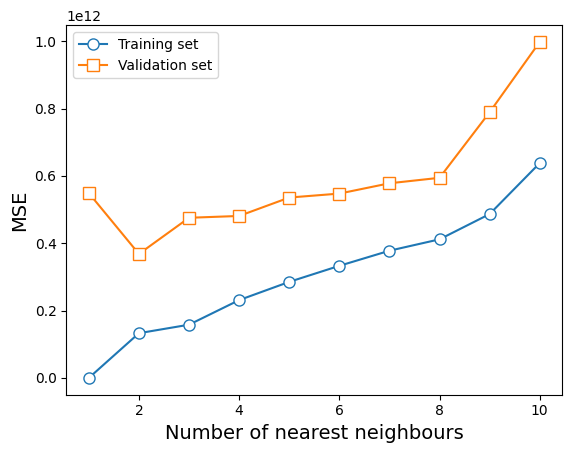

In [11]:
MSE_train = []
MSE_valid = []

k_max = 11
k_range = range(1, k_max)
for k in k_range:
    mod = createModel(k)
    scores = cross_validate(mod, X_train, y_train,
                            cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    MSE_train = np.append(MSE_train, -scores['train_score'].mean())
    MSE_valid = np.append(MSE_valid, -scores['test_score'].mean())

plt.plot(k_range, MSE_train, "o-", markersize=8, markerfacecolor='white', label='Training set')
plt.plot(k_range, MSE_valid, "s-", markersize=8, markerfacecolor='white', label='Validation set')
plt.xlabel('Number of nearest neighbours', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend(loc='best')
plt.show()

### Training of the model

In [12]:
mod = createModel(3)
mod.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(categories=[array(['Agriculture', 'Industries', 'Matières résiduelles',
       'Résidentiel, commercial et institutionnel', 'Transports',
       'Électricité'], dtype=object)]))]),
                                                  [1])])),
                ('regression', KNeighborsRegressor(n_neighbors=3))])

### Evaluation on the test set

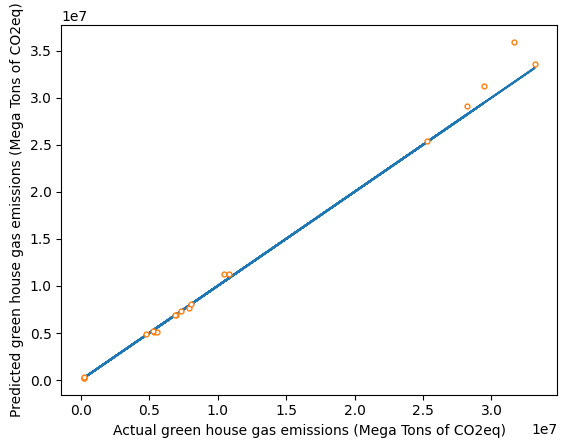

In [13]:
y_pred = mod.predict(X_test)
plt.plot(y_test, y_test, "-")
plt.plot(y_test, y_pred, ".", markersize=7, markerfacecolor='white')
plt.xlabel('Actual green house gas emissions (Mega Tons of CO2eq)')
plt.ylabel('Predicted green house gas emissions (Mega Tons of CO2eq)')
plt.show()

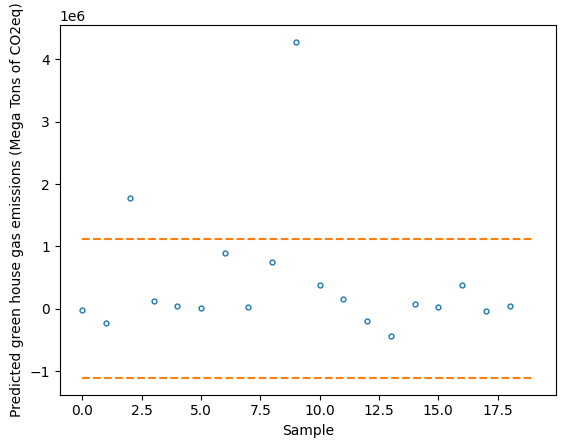

In [14]:
y_pred = mod.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred, squared=False)
plt.plot(y_pred-y_test, ".", markersize=7, markerfacecolor='white')
plt.plot([0, len(y_pred)], [RMSE, RMSE], '--', color='#ff7f0e')
plt.plot([0, len(y_pred)], [-RMSE, -RMSE], '--', color='#ff7f0e')
plt.xlabel('Sample')
plt.ylabel('Predicted green house gas emissions (Mega Tons of CO2eq)')
plt.show()

### Evaluation on the various sectors of full data set

Note: this evaluation isn't entirely valid as it combines data from the training and test set. It can however give a feeling of the validity of the model over the period the data set covers.

In [15]:
@interact(sector=widgets.Dropdown(options=df.Secteur.unique(),
                                description='Sector'))
def total_emissions_sector(sector):
    """
    Total green house gas emissions for a sector over the years
    """
    X_sect = np.c_[df[df.Secteur==sector].Annee, df.Secteur[df.Secteur==sector]]
    y_sect = np.c_[df[df.Secteur==sector].EmissionsTotales]
    y_pred = mod.predict(X_sect)
    plt.plot(df[df.Secteur==sector].Annee, y_pred/1E6)
    plt.plot(df[df.Secteur==sector].Annee, y_sect/1E6, 'o', markersize=7, markerfacecolor='white')
    plt.xlabel('Year')
    plt.ylabel("Green House Gas Emission (Equ. Mega Tons of CO$_2$)")
    plt.xticks(rotation=45,  ha='right')
    plt.show()

interactive(children=(Dropdown(description='Sector', options=('Agriculture', 'Industries', 'Matières résiduell…

## Critical thinking

1. Would the KNN model be a good model to predict future green house gas emissions?<br>
Explain your answer<br>
*Hint: You may wish to try to forecast the next ten years. What do you observe and why do you observe this?*

2. Would a linear regression model be a good model to try for this data set?<br>
Explain your answer<br>
*Hint: You may wish to try to build such a linear model. What do you observe and why do you observe this?*